In [4]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable
print(f"cuda, {torch.cuda.is_available()}")


cuda, False


### 平均気温を推定

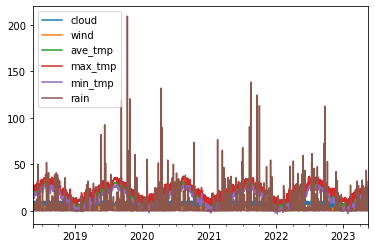

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/aweglteo/tokyo_weather_data/main/data.csv", parse_dates=True, index_col=0)
df.plot()

### データセット前処理

In [10]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['cloud', 'wind', 'ave_tmp', 'max_tmp', 'min_tmp', 'rain']])

# テスト用と訓練用で分割（7:3）
df_train, df_test = train_test_split(df_scaled, test_size=0.3, shuffle=False)

window_size = 20
n_data = len(df) - window_size + 1 -1

n_dim = df_train.shape[1]
n_train = len(df_train) - window_size + 1 - 1
n_test = len(df_test) - window_size + 1 - 1

# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i+window_size]

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i+window_size]

# 訓練ラベルの用意。今回は平均気温を予測する
train_labels =train_labels[:, 2]

train = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

### LSTM作成

In [12]:
# 多変量を入力して、１変数の予測結果を返すLSTNモデル.
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        # hidden state
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        # cell state
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim) 
        y = self.fc(hn)
        y = y.reshape(self.n_output, -1)

        return y


feature_size  = 6
n_hidden  = 64
n_layers  = 1

net = MyLSTM(feature_size, n_hidden, n_layers)
summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              18,432
├─Linear: 1-2                            65
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0

### 学習

In [13]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_history = []
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")
epochs = 200

net.to(device)

MyLSTM(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x) 
        y = y.to('cpu')
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, 'Loss_Train:', tmp_loss)

c:\Users\kenta\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\kenta\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss_Train: 0.023954236703658743
Epoch: 1 Loss_Train: 0.006516525910017894
Epoch: 2 Loss_Train: 0.005763615202528262
Epoch: 3 Loss_Train: 0.005169401759681816
Epoch: 4 Loss_Train: 0.004997298560458206
Epoch: 5 Loss_Train: 0.004530949602993797
Epoch: 6 Loss_Train: 0.004273751256978213
Epoch: 7 Loss_Train: 0.004088562164716201
Epoch: 8 Loss_Train: 0.0038915767369049024
Epoch: 9 Loss_Train: 0.004100374123617445
Epoch: 10 Loss_Train: 0.004033122364333914
Epoch: 11 Loss_Train: 0.003938596058056675
Epoch: 12 Loss_Train: 0.004019950762749576
Epoch: 13 Loss_Train: 0.004055797133032539
Epoch: 14 Loss_Train: 0.0039885253254194845
Epoch: 15 Loss_Train: 0.003896915330493819
Epoch: 16 Loss_Train: 0.003891738646133389
Epoch: 17 Loss_Train: 0.003839521808826941
Epoch: 18 Loss_Train: 0.003833131121826314
Epoch: 19 Loss_Train: 0.0037187894547565116
Epoch: 20 Loss_Train: 0.003717591422369763
Epoch: 21 Loss_Train: 0.0036698321644623305
Epoch: 22 Loss_Train: 0.0038335503106484087
Epoch: 23 Loss_T

### 学習結果

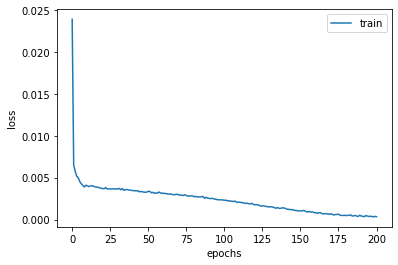

In [15]:
# 損失関数を描く
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### 予測

C:\Users\kenta\AppData\Local\Temp/ipykernel_72272/871731722.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train[k])


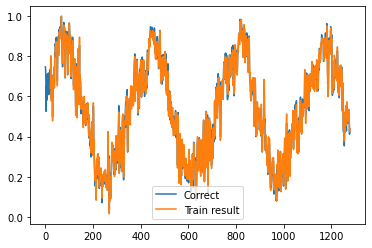

In [20]:
predicted_train_plot = []
net.eval()

for k in range(n_train):
    x = torch.tensor(train[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_train_plot.append(y[0].item())

plt.plot(range(len(df_train)), df_train[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Train result')
plt.legend()
plt.show()

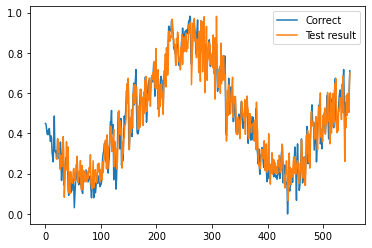

In [21]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_test_plot.append(y[0].item())

plt.plot(range(len(df_test)), df_test[:, 2], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()
